In [65]:
import torch
import h5py
import numpy as np

from fomo.dataset import DescriptorDatasets
from vae.vae_pl import DescriptorVAE, ModalVAE

import matplotlib.pyplot as plt

In [2]:
test_data = DescriptorDatasets("data/test.h5")

model = DescriptorVAE.load_from_checkpoint("/data/compoundx/anand/fomo-vaem/descriptor/lightning_logs/version_1/checkpoints/epoch=82-step=166000.ckpt",  map_location=torch.device("cpu") , valid_dataset=test_data, latent_dim=8, batch_size=64  )

In [3]:
with h5py.File("data/train.h5", "r") as f:
    print(f.keys())
    bl = f["bl"][:]
    mu_l = f["mu_l"][:]
    mu_s = f["mu_s"][:]
    mu_w = f["mu_w"][:]
    x_s = f["x_s"][:]

<KeysViewHDF5 ['bl', 'log_var_l', 'log_var_s', 'log_var_w', 'mu_l', 'mu_s', 'mu_w', 'r_l', 'r_s', 'r_w', 'x_l', 'x_s', 'x_w', 'z_l']>


In [4]:
index = bl>np.percentile(bl, 90)
mu_l_x = mu_l[index]

In [5]:
mu_l_x.mean(axis=0)

array([ 0.11617435, -0.331851  ,  0.41173646, -0.00067722, -0.36633047,
       -0.05619764, -0.4007128 ,  0.29439592], dtype=float32)

In [6]:
mu_l.mean(0)

array([ 0.01637789, -0.03775182,  0.04853267, -0.00668434, -0.04712929,
       -0.00077454, -0.02679514, -0.04512257], dtype=float32)

In [52]:
np.absolute(mu_l_x.mean(axis=0)-mu_l.mean(0))

array([0.09979646, 0.29409918, 0.3632038 , 0.00600711, 0.31920117,
       0.05542309, 0.37391764, 0.3395185 ], dtype=float32)

In [54]:
k_list = np.argsort(np.absolute(mu_l_x.mean(axis=0)-mu_l.mean(0)))[::-1]

[64 59 62 44 51 60  5 18 21  0 22 41  8 42 48 20 29 32 54 43 15  6 57 17
 50 11 52  3 16 58 23 33 36  2 45  4 30 53 26 61 55 63 34 47 14 24  1 39
 19 35  9 12  7 46 25 27 40 13 56 38 37 28 10 49 31]
[62 64 27 29 18 11 44 10 51 59  7 31 21 26  8 50 15 32 24  0  9 25 46 54
 36 41 17 22  6 43 60  4 48 40 37 30 55 42 28 63 20 58 13 57 38 49 47 33
 53 14 12  3 16 34 39 52 35 23 61  1 45 19 56  2  5]
[ 3 21 33 27 24 11 52  8 62 41 54 19 32  0 29 64 34  5 38 12 20 22 16  9
 51 25 46 49 57 26 23 59  2 31  6 45 47 55 48 60 10 42 40 56  1 13  4 30
 43 63 18 58 35 61 37 17 44 28 50 15 53 36 14 39  7]
[36 60 18 29 17  7 13 25 28  0 32 26  4 12 46 52 20 44 64 27  9 41 57 37
  3 31 22 48 15 16 14  1 33 10 51 24 59 40 39 58 30 11 62 21  6 35 42 63
 56 55  8 47 49  2 23 43 19 38 61 54 34 53 50 45  5]
[41 29 13  3 51 31 52 16 10  9 57 12 64  1 36 18 27 42 62  4 14 33 26 20
 11 48 61 21 17 59 23 28  7 43 54  5 46 58 44 63 53 24 19 56 40 47 49 39
 15 50 35  6 30 38 60 32  0  8 55 45 25 22 37  2 34]


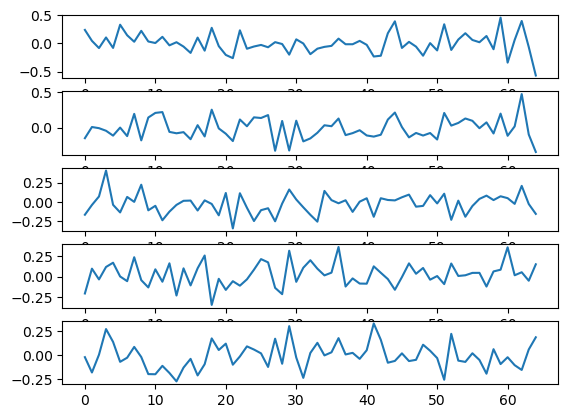

In [63]:
fig, axes = plt.subplots(5,1)
for i, k in enumerate(k_list[:5]):

    latent = mu_l.mean(axis=0)
    latent[k] = mu_l_x.mean(axis=0)[k]
    latent = torch.Tensor(latent[None,:])
    out = model.model.decoder.decode(latent)[0][0,:].cpu().detach().numpy()
    mean_l1 = np.concatenate([mu_w.mean(axis=0), mu_s.mean(axis=0), np.array(bl.mean(axis=0))[np.newaxis]])
    axes[i].plot(mean_l1-out)
    # axes[i].plot(out)

    print(np.argsort(np.absolute(mean_l1-out))[::-1])


In [66]:
model_w = ModalVAE.load_from_checkpoint("/data/compoundx/anand/fomo-vaem/grouped_weather/lightning_logs/version_4/checkpoints/epoch=199-step=100000.ckpt", map_location=torch.device("cpu"), inp_shape=(1,36,3), modality="grouped_weather", beta=0.0001, batch_size=16)
model_s = ModalVAE.load_from_checkpoint("/data/compoundx/anand/fomo-vaem/grouped_states/lightning_logs/version_6/checkpoints/epoch=134-step=67500.ckpt", map_location=torch.device("cpu"), inp_shape=(1,104,2), modality="grouped_states", beta=0.0001, batch_size=16)

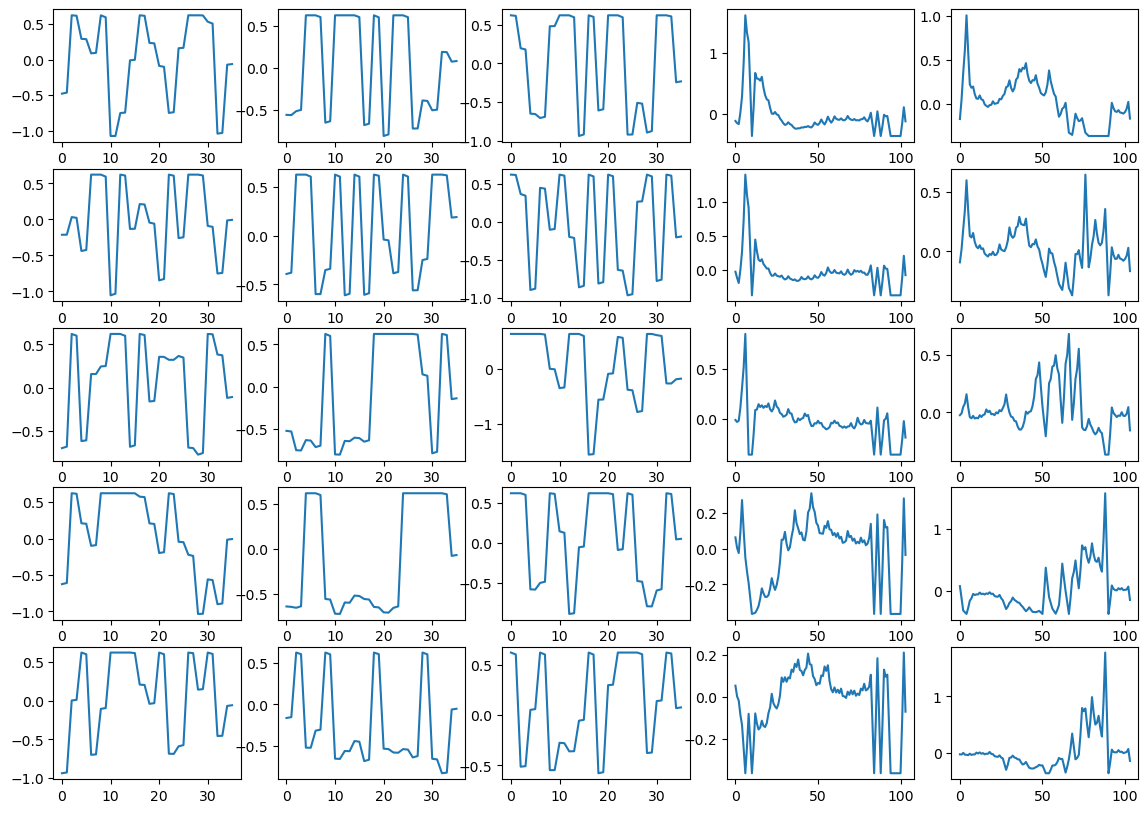

In [86]:
fig, axes = plt.subplots(5,5, figsize=(14,10))
for i, k in enumerate(k_list[:5]):

    latent = mu_l.mean(axis=0)
    latent[k] = mu_l_x.mean(axis=0)[k]
    latent = torch.Tensor(latent[None,:])
    out = model.model.decoder.decode(latent)[0][0,:].cpu().detach().numpy()
    mean_l1 = np.concatenate([mu_w.mean(axis=0), mu_s.mean(axis=0), np.array(bl.mean(axis=0))[np.newaxis]])
    # axes[i].plot(out)
    weather = model_w.model.decoder(torch.Tensor(out[None,:32])).cpu().detach().numpy()[0,0,:,:]
    state = model_s.model.decoder(torch.Tensor(out[None,32:64])).cpu().detach().numpy()[0,0,:,:]

    for j in range(3):
        axes[i,j].plot(weather[:,j])
        
    for l in range(2):
        axes[i,3+l].plot(state[:,l])



In [67]:
out

array([-0.0510289 ,  0.14698312,  0.00479807,  1.1425215 , -0.5608017 ,
       -1.0635554 , -0.06685065, -0.15675469, -0.05125789,  0.21501648,
       -0.01782676,  0.13595635,  0.30072352,  0.21620534,  0.11967988,
       -1.2608836 ,  0.19015673,  0.01653031, -0.3362506 , -0.0810169 ,
        0.04803951,  0.06335078, -0.23631528, -0.07500729, -0.03226192,
        0.08640548, -0.12405262, -0.14661454,  0.13521822, -0.21782039,
       -0.00246927,  0.27213737,  0.00878725, -0.12647176, -0.02906428,
       -0.03314134,  0.48982072, -0.05620273,  1.1248078 ,  0.07515787,
       -0.09645317, -0.5240861 , -0.0488666 ,  0.07510122, -0.00892032,
        0.01673669,  0.24090321,  0.0301744 ,  0.21309425, -0.12665693,
        0.4106424 ,  0.18407598, -0.184492  ,  0.03921273,  0.04177191,
        0.00145086,  0.08998919,  0.29556128, -0.07778171, -0.3204684 ,
       -0.72963494,  0.07685211,  0.85486466, -0.07507822, -0.16408269],
      dtype=float32)

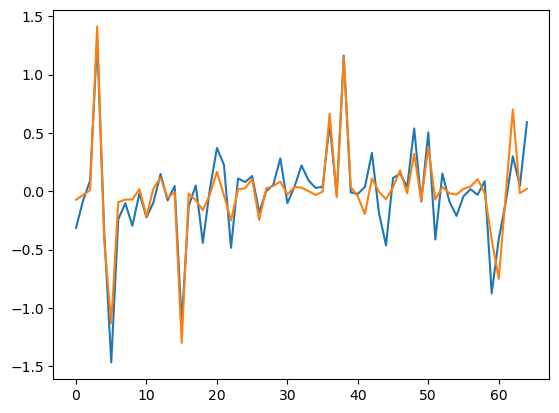

In [46]:
mean_l1[]

(65,)

()